Facial Keypoint Detection


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np 
import pandas as pd 
import os
import missingno as msno 

from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
%matplotlib inline 

checker = 0
for dirname, _, filenames in os.walk('drive/My Drive/facial_keypoints_data/'):
    for filename in filenames:
        if (os.path.join(dirname, filename) is not None): checker += 1
if checker == 4: print('All files are available')

# EDA

In [0]:
training = pd.read_csv('drive/My Drive/facial_keypoints_data/training/training.csv')

In [0]:
#! TODO: check how variables behaves - quartiles, intervals
#  maybe there is a way to create challenger simply by putting coordinates as means/medians
training.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7039.000000,7039.000000,7036.000000,7036.000000,2271.000000,2271.000000,2267.000000,2267.000000,2268.000000,2268.000000,2268.000000,2268.000000,2270.000000,2270.000000,2225.000000,2225.000000,2270.000000,2270.000000,2236.000000,2236.000000,7049.000000,7049.000000,2269.000000,2269.000000,2270.000000,2270.000000,2275.000000,2275.000000,7016.000000,7016.000000
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,22.384504,38.033495,56.068513,29.332678,79.482826,29.734861,39.322137,29.502998,15.871177,30.428166,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
std,3.448233,3.152926,3.083230,3.033621,2.690354,2.307332,3.405852,2.881438,2.350268,2.311907,3.057122,2.910368,3.485485,3.078134,3.986224,3.773744,3.209641,3.106869,3.622533,3.865772,4.280038,5.720567,4.079063,4.579724,3.964552,4.417814,3.323060,5.222500,4.269961,5.407844
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,3.980117,25.123828,17.888717,15.859361,32.206432,10.522325,6.921014,16.476000,3.826243,13.224453,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082895,35.900451,28.783339,36.327681,58.039339,36.626283,71.716503,36.085523,35.506126,36.766783,20.585808,36.534382,54.515587,27.617244,77.673916,27.667948,37.552286,27.790607,13.562183,28.206046,46.602370,59.292697,61.257143,72.875707,30.797646,73.256472,46.494571,69.396748,46.573703,75.549715
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,22.535954,37.867071,56.244975,29.528872,79.784229,29.773813,39.298848,29.569347,15.785709,30.320160,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326
75%,68.024752,39.258449,31.768334,39.566729,60.519810,39.260348,75.015645,39.373489,37.753571,39.192917,24.237701,39.415051,57.946415,31.158830,81.590720,31.835621,40.917160,31.251664,17.999040,32.654768,50.330437,66.492686,65.376243,78.879123,35.101302,78.956357,49.296488,76.221644,50.677631,82.233993
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,61.428580,70.746797,79.787831,60.875896,94.269957,60.500298,76.582388,62.083177,58.418216,66.751329,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


How does y look like?

In [0]:
training.loc[:, training.columns != 'Image'].head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


How does X look like?

In [0]:
training['Image'].head(3)

0    238 236 237 238 240 240 239 241 241 243 240 23...
1    219 215 204 196 204 211 212 200 180 168 178 19...
2    144 142 159 180 188 188 184 180 167 132 84 59 ...
Name: Image, dtype: object

### Missing values



Check how many NAs are in each column




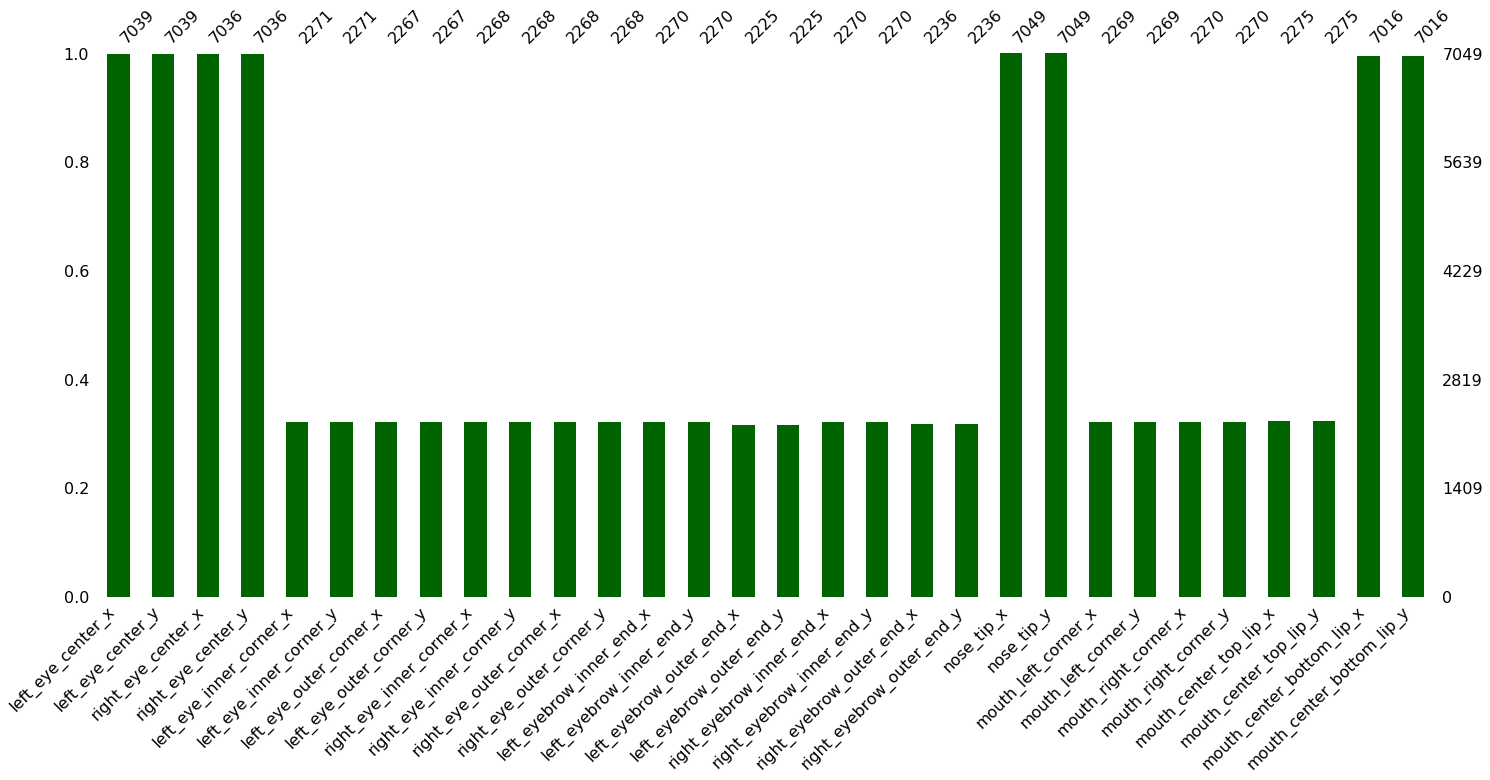

In [0]:
msno.bar(training[training.columns[:-1]], color='darkgreen') 

In [0]:
# check precisely how many NAs are in each colum
# training.isna().sum()

### Drop NAs



In [0]:
# drop NA rows
training = training.dropna()
#training.fillna(method = 'ffill',inplace = True)

In [0]:
training.shape, type(training)

((2140, 31), pandas.core.frame.DataFrame)

### Visualization


In [0]:
training['Image'] = training['Image'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape((96,96)))

In [0]:
training['Image']

0       [[238, 236, 237, 238, 240, 240, 239, 241, 241,...
1       [[219, 215, 204, 196, 204, 211, 212, 200, 180,...
2       [[144, 142, 159, 180, 188, 188, 184, 180, 167,...
3       [[193, 192, 193, 194, 194, 194, 193, 192, 168,...
4       [[147, 148, 160, 196, 215, 214, 216, 217, 219,...
                              ...                        
7044    [[71, 74, 85, 105, 116, 128, 139, 150, 170, 18...
7045    [[60, 60, 62, 57, 55, 51, 49, 48, 50, 53, 56, ...
7046    [[74, 74, 74, 78, 79, 79, 79, 81, 77, 78, 80, ...
7047    [[254, 254, 254, 254, 254, 238, 193, 145, 121,...
7048    [[53, 62, 67, 76, 86, 91, 97, 105, 105, 106, 1...
Name: Image, Length: 7049, dtype: object

In [0]:
def get_image_and_dots(df, index):
    image = plt.imshow(df['Image'][index],cmap='gray')
    l = []
    for i in range(1,31,2):
        l.append(plt.plot(df.loc[index][i-1], df.loc[index][i], 'ro'))
        
    return image, l

def plot_faces(plot_dim = 6):
  fig = plt.figure(figsize=(12, 12))
  fig.subplots_adjust(
      left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

  for i in range(plot_dim*plot_dim):
      ax = fig.add_subplot(plot_dim, plot_dim, i + 1, xticks=[], yticks=[])
      get_image_and_dots(training, i)

  # plt.savefig('drive/My Drive/visualization.png', bbox_inches='tight')
  plt.show()

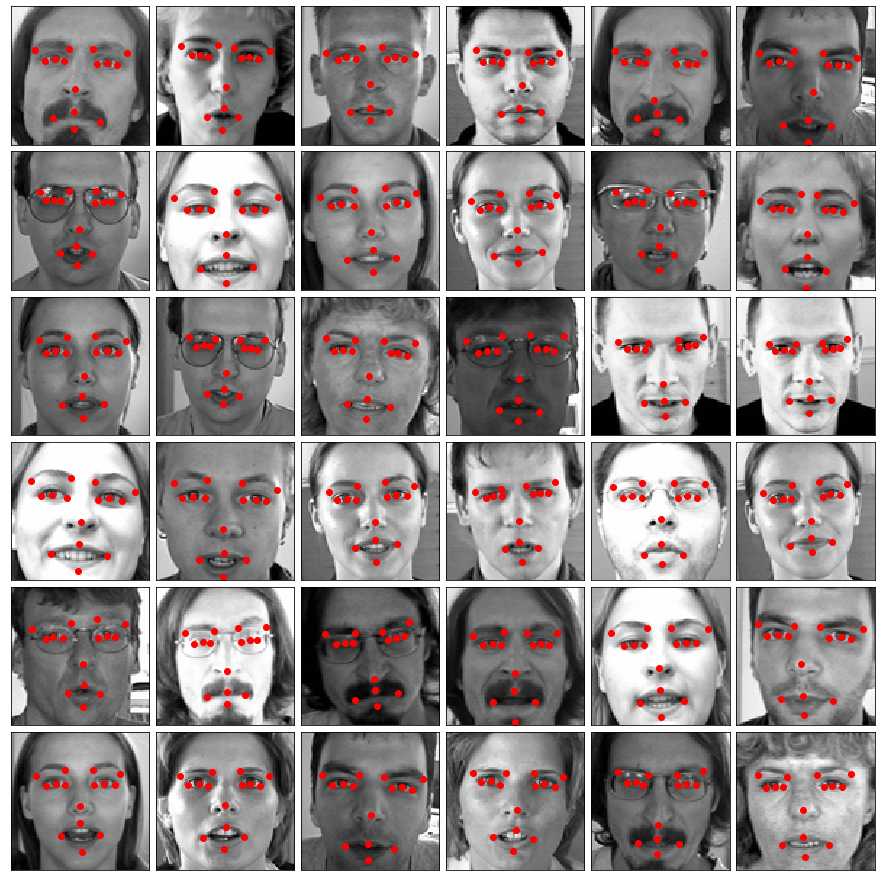

In [0]:
plot_faces(6)

Now we need to create X and Y matrixes. 

X's values are images (reshaped strings from datasource)

Y's are all features - 31 distinct features of human faces



In [0]:
X = np.asarray([training['Image']], dtype=np.uint8).reshape(training.shape[0],96,96,1)
y = training.drop(['Image'], axis=1)

In [0]:
print(f"X's shape: {X.shape}")
print(f"y's shape: {y.shape}")
print(f"X type: {type(X)}, Y type: {type(y)}")
yn = y.to_numpy()
print(f"yn type: {type(yn)}, yn shape: {yn.shape}")

X's shape: (2140, 96, 96, 1)
y's shape: (2140, 30)
X type: <class 'numpy.ndarray'>, Y type: <class 'pandas.core.frame.DataFrame'>
yn type: <class 'numpy.ndarray'>, yn shape: (2140, 30)


# Preprocessing



### Creating X and y

In [0]:
training = pd.read_csv('drive/My Drive/facial_keypoints_data/training/training.csv')
training['Image'] = training['Image'].apply(lambda x: np.fromstring(x, sep=' '))
training = training.dropna()

# scale pixel values to [0, 1]
X = np.vstack(training['Image'].values) / 255.
X = X.astype(np.float32)

y = training[training.columns[:-1]].values
y = (y - 48) / 48  # scale target coordinates to [-1, 1]
X, y = shuffle(X, y, random_state=42)  # shuffle train data
y = y.astype(np.float32)

### Train and test split

Now we need to create train and test sets for all models

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=666)

# RMSE definition

In [3]:
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Saving model function

In [0]:
from tensorflow.keras.models import model_from_json

def save_model(model,name):
    json_string = model.to_json()
    open('drive/My Drive/'+name+'_architecture.json', 'w').write(json_string)
    model.save_weights('drive/My Drive/'+name+'_weights.h5')
    
def load_model(name):
    model = model_from_json(open('drive/My Drive/'+name+'_architecture.json').read())
    model.load_weights('drive/My Drive/'+name +'_weights.h5')
    return(model)

# **1st Model - Random Forest / XGBoost**

In [0]:
# random forest implementation

# **2nd Model - MLP**



In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

In [15]:
model_mlp = Sequential([
  Dense(256, input_dim=X_train.shape[1], activation = 'relu'),
  Dropout(0.1),

  Dense(128, activation = 'relu'),
  Dropout(0.3),
  
  Dense(64, activation = 'relu'),
  Dense(30)
])

model_mlp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               2359552   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 30)                1950      
Total params: 2,402,654
Trainable params: 2,402,654
Non-trainable params: 0
____________________________________________

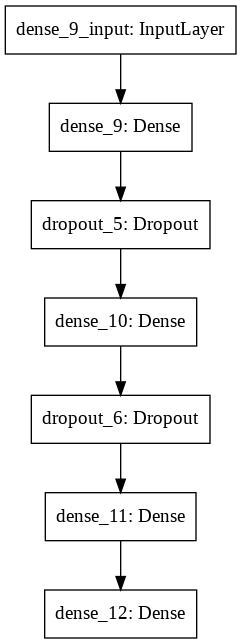

In [49]:
from keras.utils import plot_model
plot_model(model_mlp, to_file='drive/My Drive/facial_keypoints_data/mlp_rmse_2249.png')

### MLP training

In [17]:
sgd = SGD(lr=0.01,
          momentum=0.9,
          nesterov=True)

model_mlp.compile(loss = root_mean_squared_error,
              optimizer = sgd)

hist_mlp = model_mlp.fit(X_train,
                     y_train,
                     epochs=500,
                     batch_size=128,
                     validation_split=0.1,
                     verbose=0)
print('Model trained')

Model trained


### Loss visualization

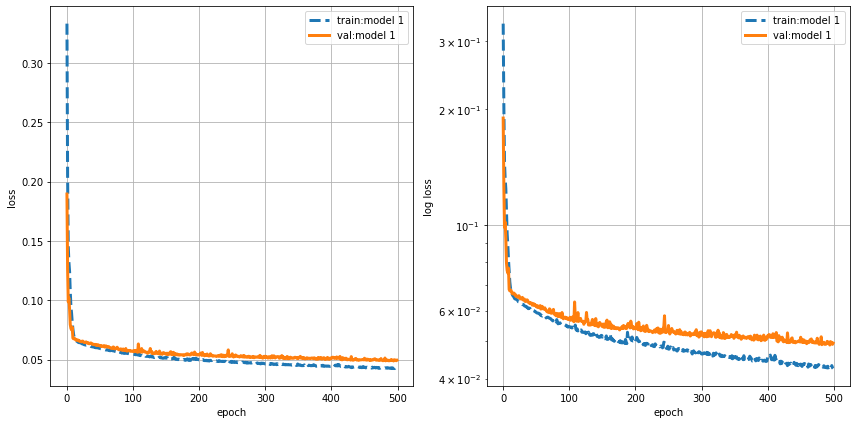

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(hist,name,plt):

    loss = hist['loss']
    val_loss = hist['val_loss']
        
    plt.plot(loss,"--", linewidth=3, label="train:"+name)
    plt.plot(val_loss, linewidth=3, label="val:"+name)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plot_loss(hist_mlp.history,"model 1",plt)
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plot_loss(hist_mlp.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")


plt.tight_layout()
# plt.savefig('drive/My Drive/MLP_loss.png', bbox_inches='tight')
plt.show()

In [21]:
loss_eval = model_mlp.evaluate(X_test, y_test, batch_size=128)
print('Test loss(RMSE):', loss_eval)
print('Rescaled RMSE:', round(loss_eval * 48, 3))

321/321 [==============================] - 0s 79us/step
Test loss(RMSE): 0.046859319672870485
Rescaled RMSE: 2.249


### Saving model and weights

In [0]:
save_model(model_mlp,"model_mlp_2249")
model_mlp = load_model("model_mlp_2249")

# **3rd Model - CNN**

In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, AvgPool2D, BatchNormalization, Dropout, Activation, MaxPool2D, LeakyReLU, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import SGD

Preprocessing for CNN (reshaping from 1d vector)



In [0]:
X_train = X_train.reshape(-1,96,96,1)
X_test = X_test.reshape(-1,96,96,1)

In [0]:
class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss') < 0.04 or logs.get('loss') < 0.02):
      print("\nReached target loss so cancelling training!")
      self.model.stop_training = True
    if epoch % 10 == 1:
      print(f"Epoch {epoch}")
      print(f"Loss :{logs.get('loss')} -- Val Loss: {logs.get('val_loss')}")
      print(f"")

callbacks = myCallback()

In [32]:
model_cnn = Sequential([
  Conv2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)),
  LeakyReLU(alpha = 0.1),

  Conv2D(32, (3,3), padding='same'),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(64, (3,3), padding='same'),
  LeakyReLU(alpha = 0.1),

  Conv2D(64, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(96, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  
  Conv2D(96, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(128, (3,3),padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  BatchNormalization(),

  Conv2D(128, (3,3),padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(256, (3,3),padding='same',use_bias=False),
  LeakyReLU(alpha = 0.1),

  Conv2D(256, (3,3),padding='same',use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(512, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),

  Conv2D(512, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),

  Flatten(),
  Dense(512,activation='relu'),
  Dropout(0.1),
  Dense(30)
])

model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 48, 48, 64)        18496     
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 48, 48, 64)       

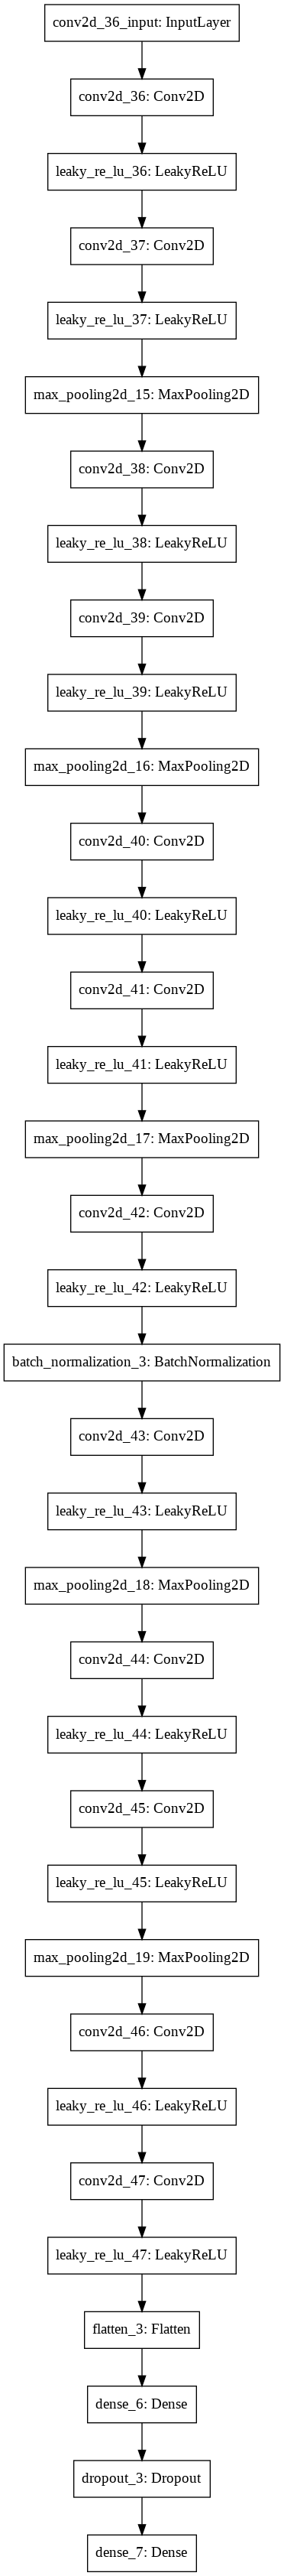

In [50]:
from tensorflow.keras.utils import plot_model
plot_model(model_cnn, to_file='drive/My Drive/facial_keypoints_data/cnn_rmse_1773.png')

In [0]:
sgd = SGD(lr=0.01,
          momentum=0.9,
          nesterov=True)

model_cnn.compile(loss = root_mean_squared_error,
              optimizer = sgd)

In [35]:
hist_cnn = model_cnn.fit(X_train,
                         y_train,
                         epochs=600,
                         batch_size=128,
                         validation_split=0.1,
                         verbose = 0,
                         callbacks=[callbacks]
                        )

Epoch 1
Loss :0.12763452021975158 -- Val Loss: 0.31327661871910095

Epoch 11
Loss :0.06840839235609307 -- Val Loss: 0.264931457055794

Epoch 21
Loss :0.059788789079002876 -- Val Loss: 0.22972629096481825

Epoch 31
Loss :0.05338935587935209 -- Val Loss: 0.16841425394618903

Epoch 41
Loss :0.046366402384396654 -- Val Loss: 0.10052916473084754

Epoch 51
Loss :0.04366268357518029 -- Val Loss: 0.0607925092617234

Epoch 61
Loss :0.04023476888948486 -- Val Loss: 0.04503280235515846

Epoch 71
Loss :0.036721730444332266 -- Val Loss: 0.04682731370513256

Epoch 81
Loss :0.03361785313525285 -- Val Loss: 0.04339196053998811

Epoch 91
Loss :0.03079077101010481 -- Val Loss: 0.04443936704934298

Epoch 101
Loss :0.03023167135092676 -- Val Loss: 0.042826540154087676

Epoch 111
Loss :0.027903973840054174 -- Val Loss: 0.043160052540210575

Epoch 121
Loss :0.026509574485320323 -- Val Loss: 0.04220050409599975

Epoch 131
Loss :0.0254330657804857 -- Val Loss: 0.04148495008984765

Epoch 141
Loss :0.0243582710

### Saving model and weights

In [0]:
save_model(model_cnn,"model_cnn_1773")
model_cnn = load_model("model_cnn_1773")

### Loss visualization

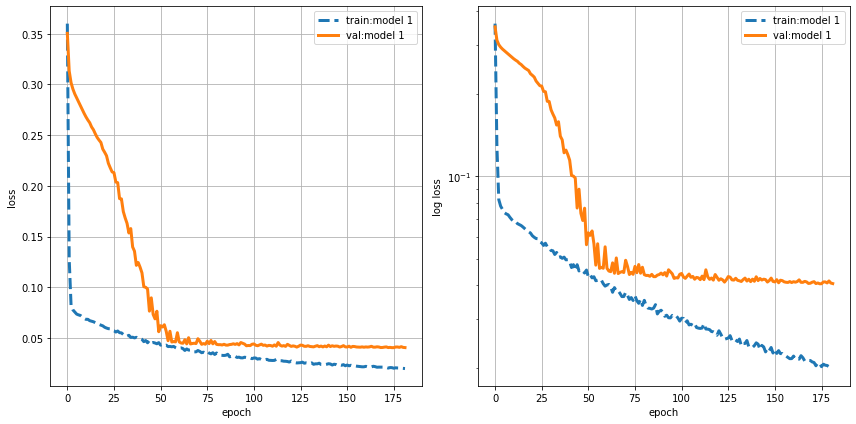

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(hist,name,plt):

    loss = hist['loss']
    val_loss = hist['val_loss']
        
    plt.plot(loss,"--", linewidth=3, label="train:"+name)
    plt.plot(val_loss, linewidth=3, label="val:"+name)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plot_loss(hist_cnn.history,"model 1",plt)
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plot_loss(hist_cnn.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")

plt.tight_layout()
# plt.savefig('drive/My Drive/CNN_loss.png', bbox_inches='tight')
plt.show()

### Evaluation

In [38]:
score = model_cnn.evaluate(X_test, y_test, verbose=0)
print('Test RMSE:', score)
# print('Test MAE:', score[1])
print('Rescaled RMSE:', round(score*48, 3))

Test RMSE: 0.036929980819795365
Rescaled RMSE: 1.773


In [0]:
y_eval = model_cnn.predict(X_test)

### Plotting predicted and real

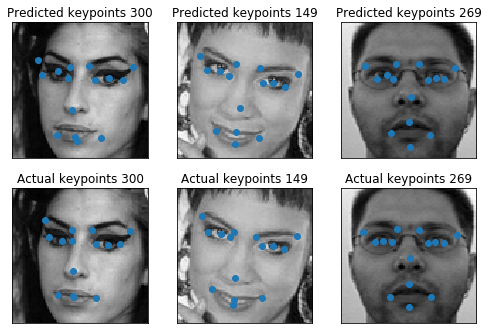

In [44]:
def plot_sample(X,y,axs):
    axs.imshow(X.reshape(96,96),cmap="gray")
    axs.scatter(48*y[0::2]+ 48,48*y[1::2]+ 48)

fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(hspace=0.13,wspace=0.0001,
                    left=0,right=1,bottom=0, top=1)
Npicture = 9
count = 1
picture_id = [300,149,269]

for ipic in picture_id:
    ax = fig.add_subplot(Npicture/3 , 3, count,xticks=[],yticks=[])        
    plot_sample(X_test[ipic],y_eval[ipic],ax)
    ax.set_title("Predicted keypoints "+ str(ipic))
    count += 1


for ipic in picture_id:
    ax = fig.add_subplot(Npicture/3 , 3, count,xticks=[],yticks=[])        
    plot_sample(X_test[ipic],y_test[ipic],ax)
    ax.set_title("Actual keypoints "+ str(ipic))
    count += 1

plt.tight_layout()
# plt.savefig('drive/My Drive/CNN_faces_test_eval.png', bbox_inches='tight')
plt.show()

# **4th Model - CNN with transfer learning**

In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, AvgPool2D, BatchNormalization, Dropout, Activation, MaxPool2D, LeakyReLU, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import SGD

## First CNN (with 8 coordinates)

### Preprocessing for CNN with few features

In [257]:
training = pd.read_csv('drive/My Drive/facial_keypoints_data/training/training.csv')
# training['Image'] = training['Image'].apply(lambda x: np.fromstring(x, sep=' '))
training.shape

(7049, 31)

Subset of all features (no NAs):


In [258]:
training_all_features = training.dropna()
training_all_features.shape

(2140, 31)

Subset with 8 features and images:

In [259]:
df_all = training.merge(training_all_features.drop_duplicates(), on=['Image'], 
                   how='left', indicator=True)
training_few_features = df_all[df_all['_merge'] == 'left_only'].iloc[:,0:31]
training_few_features = training_few_features.dropna(axis=1, thresh=len(training_few_features) - 34)
training_few_features.shape

(4908, 9)

Separating test set (for final model) from training_all_features

In [260]:
training_all_features = shuffle(training_all_features, random_state=666)
test_final = training_all_features.head(300)
training_all_features = training_all_features.tail(len(training_all_features) - 300)
training_all_features.shape

(1840, 31)

Combining training_few_features with training_all_features

In [261]:
print(training_few_features.shape)
print(training_all_features.shape)

(4908, 9)
(1840, 31)


In [0]:
training_few_features.columns = ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']

In [254]:
training_all_features[['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']].shape

(1840, 9)

In [0]:
training_cnn = pd.concat([training_few_features, training_all_features[['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']]])

In [241]:
training_cnn.shape

(6748, 9)

### Train/test split for CNN with few features

In [0]:
training_cnn['Image'] = training_cnn['Image'].apply(lambda x: np.fromstring(x, sep=' '))
training_cnn = training_cnn.dropna()
# scale pixel values to [0, 1]
X = np.vstack(training_cnn['Image'].values) / 255.
X = X.astype(np.float32)

y = training_cnn[training_cnn.columns[:-1]].values
y = (y - 48) / 48  # scale target coordinates to [-1, 1]
X, y = shuffle(X, y, random_state=42)  # shuffle train data
y = y.astype(np.float32)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=666)

In [64]:
X_train = X_train.reshape(-1,96,96,1)
X_test = X_test.reshape(-1,96,96,1)
print(X_train.shape)
print(X_test.shape)

(5694, 96, 96, 1)
(1005, 96, 96, 1)


### CNN with few features training

In [0]:
class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss') < 0.04 or logs.get('loss') < 0.03):
      print("\nReached target loss so cancelling training!")
      self.model.stop_training = True
    if epoch % 10 == 1:
      print(f"Epoch {epoch}")
      print(f"Loss :{logs.get('loss')} -- Val Loss: {logs.get('val_loss')}")
      print(f"")

callbacks = myCallback()

In [76]:
model_cnn_ff = Sequential([
  Conv2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)),
  LeakyReLU(alpha = 0.1),

  Conv2D(32, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(64, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  Dropout(0.1),

  Conv2D(64, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(96, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  Dropout(0.1),
  
  Conv2D(96, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(128, (3,3),padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  BatchNormalization(),
  Dropout(0.1),

  Conv2D(128, (3,3),padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  # Conv2D(256, (3,3),padding='same',use_bias=False),
  # LeakyReLU(alpha = 0.1),

  # Conv2D(256, (3,3),padding='same',use_bias=False),
  # LeakyReLU(alpha = 0.1),
  # MaxPool2D(pool_size=(2, 2)),

  # Conv2D(512, (3,3), padding='same', use_bias=False),
  # LeakyReLU(alpha = 0.1),

  # Conv2D(512, (3,3), padding='same', use_bias=False),
  # LeakyReLU(alpha = 0.1),

  Flatten(),
  Dense(256,activation='relu'),
  Dropout(0.1),
  Dense(8)
])

model_cnn_ff.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_64 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 48, 48, 64)        18432     
_________________________________________________________________
leaky_re_lu_66 (LeakyReLU)   (None, 48, 48, 64)       

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model_cnn_ff, to_file='drive/My Drive/facial_keypoints_data/cnn_ff_rmse_1773.png')

In [0]:
sgd = SGD(lr=0.01,
          momentum=0.9,
          nesterov=True)

model_cnn_ff.compile(loss = root_mean_squared_error,
              optimizer = sgd)

In [78]:
hist_cnn_ff = model_cnn_ff.fit(X_train,
                        y_train,
                        epochs=500,
                        batch_size=128,
                        validation_split=0.1,
                        verbose = 0,
                        callbacks=[callbacks]
                     )

Epoch 1
Loss :0.08841940549483623 -- Val Loss: 0.14206548411595193

Epoch 11
Loss :0.06788186866217158 -- Val Loss: 0.11899668163897699

Epoch 21
Loss :0.05812215867287288 -- Val Loss: 0.05705830975059877

Epoch 31
Loss :0.05374510921276146 -- Val Loss: 0.052932603225896234

Epoch 41
Loss :0.04999768507145607 -- Val Loss: 0.04974794336839726

Epoch 51
Loss :0.047272766629854836 -- Val Loss: 0.04943992294240416

Epoch 61
Loss :0.045083645984216374 -- Val Loss: 0.049025463639644155

Epoch 71
Loss :0.04333841613698155 -- Val Loss: 0.045596616205416225

Epoch 81
Loss :0.041450633528547116 -- Val Loss: 0.046530621995528536

Epoch 91
Loss :0.039693378106887965 -- Val Loss: 0.04454194967422569

Epoch 101
Loss :0.03813929405647921 -- Val Loss: 0.04374284214879337

Epoch 111
Loss :0.03675793919633786 -- Val Loss: 0.04424850411320987

Epoch 121
Loss :0.03561080901924983 -- Val Loss: 0.04318311627496753

Epoch 131
Loss :0.03480380731376701 -- Val Loss: 0.04774684849799725

Epoch 141
Loss :0.03377

#### Loss visualization

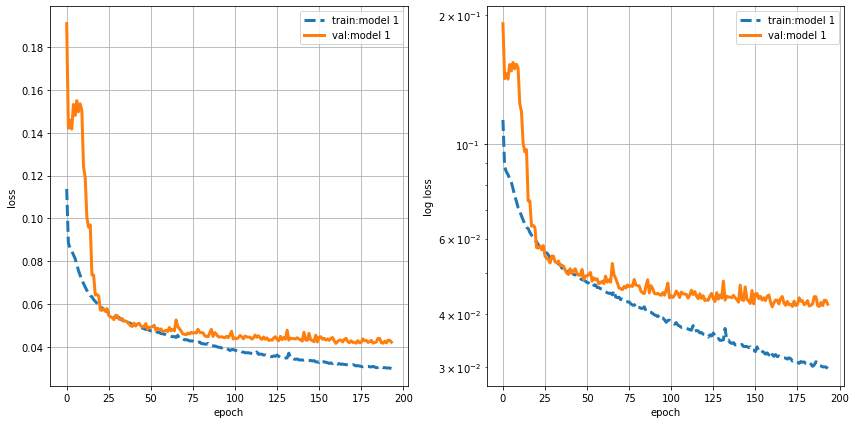

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(hist,name,plt):

    loss = hist['loss']
    val_loss = hist['val_loss']
        
    plt.plot(loss,"--", linewidth=3, label="train:"+name)
    plt.plot(val_loss, linewidth=3, label="val:"+name)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plot_loss(hist_cnn_ff.history,"model 1",plt)
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plot_loss(hist_cnn_ff.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")

plt.tight_layout()
plt.show()

#### Evaluation

In [80]:
score = model_cnn_ff.evaluate(X_test, y_test, verbose=0)
print('Test RMSE:', score)
print('Rescaled RMSE:', score*48)

Test RMSE: 0.04530836712216856
Rescaled RMSE: 2.174801621864091


#### Saving weights

In [0]:
save_model(model_cnn_ff,"model_cnn_ff_2174")
model_cnn_ff = load_model("model_cnn_ff_2174")

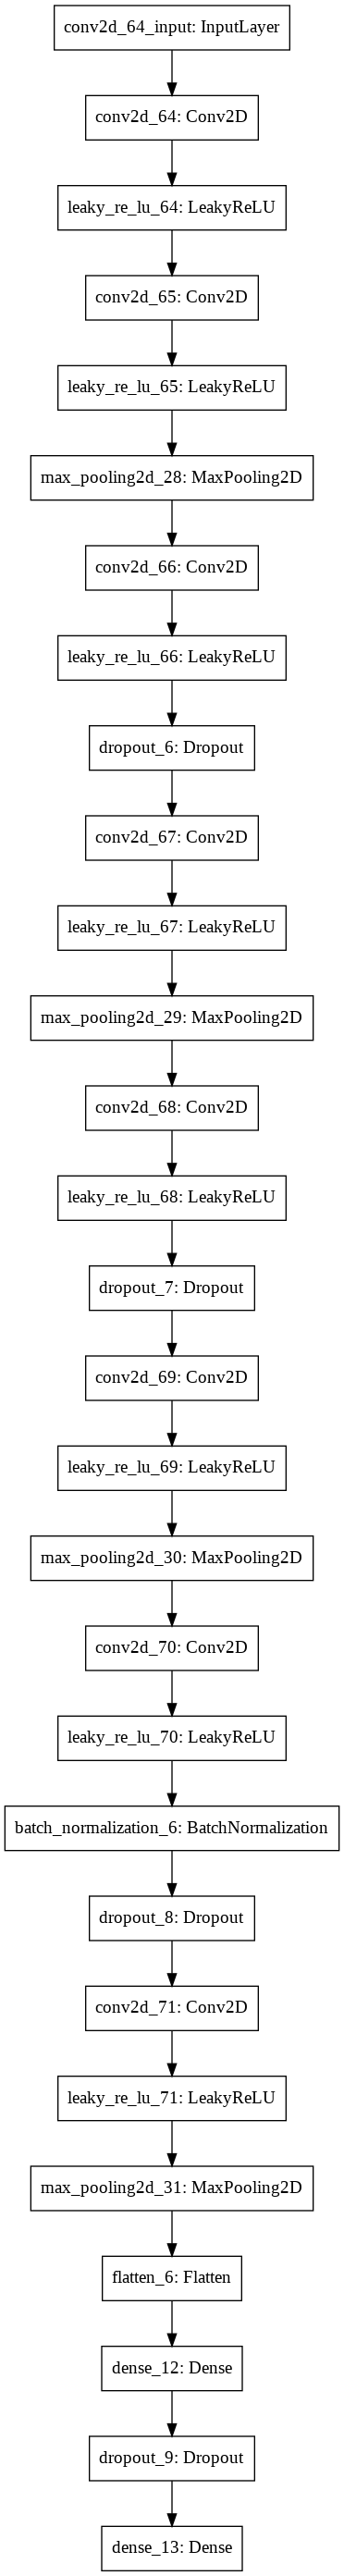

In [82]:
from tensorflow.keras.utils import plot_model
plot_model(model_cnn_ff, to_file='drive/My Drive/facial_keypoints_data/cnn__ff_rmse_2174.png')

## Preparing for transfer learning

In [83]:
model_cnn_ff.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_64 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 48, 48, 64)        18432     
_________________________________________________________________
leaky_re_lu_66 (LeakyReLU)   (None, 48, 48, 64)       

In [171]:
last_layer = model_cnn_ff.get_layer('max_pooling2d_31')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# for layer in model.layers:
#   layer.trainable = False

last layer output shape:  (None, 6, 6, 128)


In [0]:
x =  Conv2D(128, (3,3), padding='same', activation='relu')(last_output)
x =  MaxPool2D(2,2)(x)
x =  Dropout(0.1)(x)

x =  Conv2D(128, (3,3), padding='same', activation='relu')(x)
x =  MaxPool2D(2,2)(x)
x =  Dropout(0.2)(x)

x =  Flatten()(x)
x =  Dense(512, activation='relu')(x)
x =  Dropout(0.2)(x)            
x =  Dense(128, activation='relu')(x)      

x =  Dense(30)(x)           


In [0]:
model_tf = Model( model_cnn_ff.input, x) 

In [0]:
# model_tf.summary()

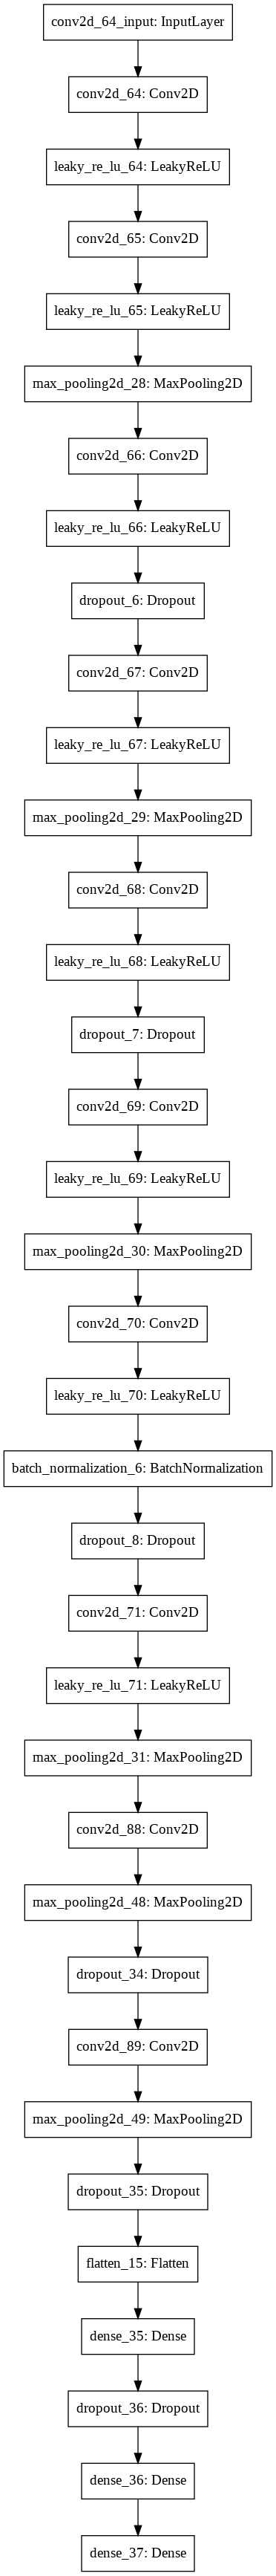

In [206]:
from tensorflow.keras.utils import plot_model
plot_model(model_tf, to_file='drive/My Drive/facial_keypoints_data/cnn_transfer_rmse_1556.png')

#### Preprocessing for all features

In [0]:
test_final['Image'] = test_final['Image'].apply(lambda x: np.fromstring(x, sep=' ').reshape((96,96)))
# training_all_features['Image'] = training_all_features['Image'].apply(lambda x: np.fromstring(x, sep=' ').reshape((96,96)))

# TEST SET
# test_final = training_all_features.head(300)
X_test = np.vstack(test_final['Image'].values) / 255.
X_test = X_test.astype(np.float32)

y_test = test_final[test_final.columns[:-1]].values
y_test = (y_test - 48) / 48  # scale target coordinates to [-1, 1]
y_test = y_test.astype(np.float32)

# # TRAIN SET
# # training_all_features = training_all_features.tail(len(training_all_features) - 300)
# X_train = np.vstack(training_all_features['Image'].values) / 255.
# X_train = X_train.astype(np.float32)

# y_train = training_all_features[training_all_features.columns[:-1]].values
# y_train = (y_train - 48) / 48  # scale target coordinates to [-1, 1]
# y_train = y_train.astype(np.float32)

### Augmenting Data

In [0]:
training_all_features['Image'] = training_all_features['Image'].apply(lambda x: np.fromstring(x, sep=' ').reshape((96,96)))

XX = training_all_features['Image'].values


yX = training_all_features[training_all_features.columns[:-1]].values
yX = yX.astype(np.float32)




In [264]:
print(XX.shape)
print(yX.shape)

(1840,)
(1840, 30)


In [0]:
from sklearn.utils import shuffle
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage
from skimage import img_as_ubyte

def augment_data(X = XX,target = yX):
  for i, t in enumerate(X):
    for j, tt in enumerate(X[i]):
      for k, ttt in enumerate(X[i][j]):
        X[i][j][k] = X[i][j][k].astype(np.uint8)
      X[i][j] = X[i][j].astype(np.uint8)
    X[i] = X[i].astype(np.uint8)

  ia.seed(1)

  imgs_aug = []
  kpss_aug = []

  for j, (image, keypt) in enumerate(zip(X,target)):
    img = X[j]
    kps = KeypointsOnImage([
      Keypoint(keypt[0], keypt[1]),
      Keypoint(keypt[2], keypt[3]),
      Keypoint(keypt[4], keypt[5]),
      Keypoint(keypt[6], keypt[7]),
      Keypoint(keypt[8], keypt[9]),
      Keypoint(keypt[10], keypt[11]),
      Keypoint(keypt[12], keypt[13]),
      Keypoint(keypt[14], keypt[15]),
      Keypoint(keypt[16], keypt[17]),
      Keypoint(keypt[18], keypt[19]),
      Keypoint(keypt[20], keypt[21]),
      Keypoint(keypt[22], keypt[23]),
      Keypoint(keypt[24], keypt[25]),
      Keypoint(keypt[26], keypt[27]),
      Keypoint(keypt[28], keypt[29])],
      shape = (96,96))


    seq = iaa.Sequential([
        iaa.Fliplr(1.0)
    ])
    img_aug, kps_aug = seq(image=img, keypoints=kps)
    act_kps = []
    act_img = []
    for i in range(len(kps.keypoints)):
      act_kps.append(kps_aug.keypoints[i].x)
      act_kps.append(kps_aug.keypoints[i].y)
    imgs_aug.append(img_aug)
    kpss_aug.append(act_kps)

  img_arr = np.array(imgs_aug)
  key_arr = np.array(kpss_aug)

  # Create X_aug and y_aug which are same dimensions as training X and y

  X_aug = np.reshape(img_arr, (img_arr.shape[0], -1)) / 255.
  X_aug = X_aug.astype(np.float32)

  y_aug = (key_arr - 48) / 48
  X_aug, y_aug = shuffle(X_aug, y_aug, random_state=42)  # shuffle train data
  y_aug = y_aug.astype(np.float32)

  return (X_aug, y_aug)

In [0]:
X_aug, y_aug = augment_data(XX, yX)

In [0]:
# TRAIN SET
# training_all_features = training_all_features.tail(len(training_all_features) - 300)
# X_train = np.hstack(training_all_features['Image'].values) / 255.
X_train = X_train.astype(np.float32)

y_train = training_all_features[training_all_features.columns[:-1]].values
y_train = (y_train - 48) / 48  # scale target coordinates to [-1, 1]
y_train = y_train.astype(np.float32)

In [277]:
X_concat = np.concatenate((X_train, X_aug), axis = 1)
y_concat = np.concatenate((y_train, y_aug), axis = 1)

ValueError: ignored

In [232]:
X_train = X_train.reshape(-1,96,96,1)
X_test = X_test.reshape(-1,96,96,1)
print(X_train.shape)
print(X_test.shape)

(1840, 96, 96, 1)
(300, 96, 96, 1)


### Training transfer learning

In [0]:
from tensorflow.keras.optimizers import RMSprop, Adam

model_tf.compile(loss = root_mean_squared_error,
              optimizer = Adam())

In [0]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 50)
# 

In [0]:
class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss') < 0.02 or logs.get('loss') < 0.01):
      print("\nReached target loss so cancelling training!")
      self.model.stop_training = True
    if epoch % 10 == 1:
      print(f"Epoch {epoch}")
      print(f"Loss :{logs.get('loss')} -- Val Loss: {logs.get('val_loss')}")
      print(f"")

callbacks = myCallback()

In [178]:
hist_cnn_af = model_tf.fit(X_train,
                        y_train,
                        epochs=500,
                        batch_size=128,
                        validation_split=0.1,
                        verbose = 0,
                        callbacks=[callbacks, es]
                     )

Epoch 1
Loss :0.10816726362071752 -- Val Loss: 0.21566860442576202

Epoch 11
Loss :0.0558567436384982 -- Val Loss: 0.051201358275569

Epoch 21
Loss :0.041808087990623743 -- Val Loss: 0.03807770136905753

Epoch 31
Loss :0.03627428583404868 -- Val Loss: 0.03380965441465378

Epoch 41
Loss :0.033022678290732244 -- Val Loss: 0.03196891972228237

Epoch 51
Loss :0.031061922960379275 -- Val Loss: 0.03172296455696873

Epoch 61
Loss :0.029575256225855454 -- Val Loss: 0.029508254288331322

Epoch 71
Loss :0.02845982313696025 -- Val Loss: 0.029453076260245365

Epoch 81
Loss :0.02703982014838912 -- Val Loss: 0.02904909217487211

Epoch 91
Loss :0.026224187363820952 -- Val Loss: 0.031047685800687126

Epoch 101
Loss :0.025319360133602423 -- Val Loss: 0.02962439110421616

Epoch 111
Loss :0.02490794702752489 -- Val Loss: 0.029127512937006744

Epoch 121
Loss :0.024102743229140407 -- Val Loss: 0.02877778883861459

Epoch 131
Loss :0.023241464759488614 -- Val Loss: 0.029253069311380386

Epoch 141
Loss :0.023

### Evaluation

In [179]:
score = model_tf.evaluate(X_test, y_test, verbose=0)
print('Test RMSE:', score)
# print('Test MAE:', score[1])
print('Rescaled RMSE:', score*48)

Test RMSE: 0.03242156776289145
Rescaled RMSE: 1.5562352526187895


### Loss visualization

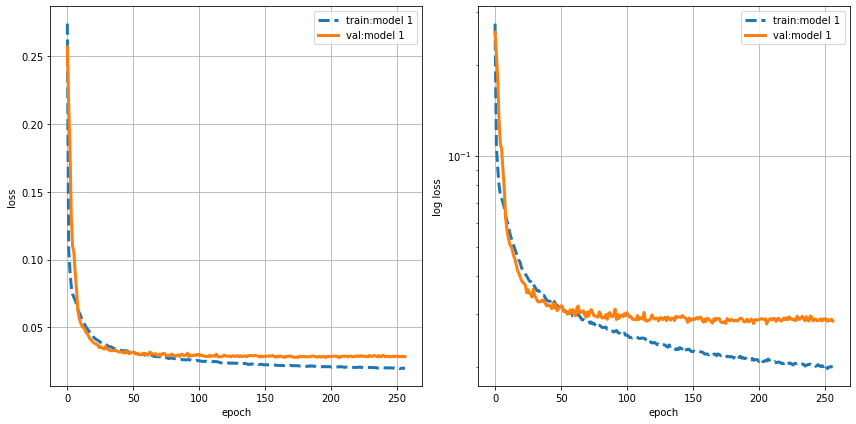

In [180]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(hist,name,plt):

    loss = hist['loss']
    val_loss = hist['val_loss']
        
    plt.plot(loss,"--", linewidth=3, label="train:"+name)
    plt.plot(val_loss, linewidth=3, label="val:"+name)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plot_loss(hist_cnn_af.history,"model 1",plt)
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plot_loss(hist_cnn_af.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")

plt.tight_layout()
plt.show()

### Saving model architecture and weights

In [0]:
save_model(model_tf,"model_cnn_transfer_1556")
model_tf = load_model("model_cnn_transfer_1556")

### Plotting predicted vs real

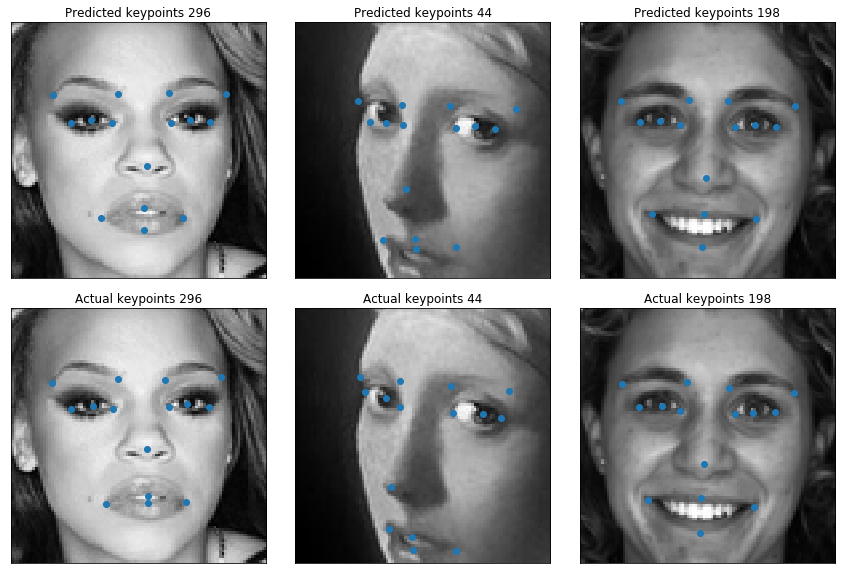

In [205]:
def plot_sample(X,y,axs):
    axs.imshow(X.reshape(96,96),cmap="gray")
    axs.scatter(48*y[0::2]+ 48,48*y[1::2]+ 48)

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0.13,wspace=0.0001,
                    left=0,right=1,bottom=0, top=1)
Npicture = 9
count = 1
picture_id = [296,44,198]
y_eval = model_tf.predict(X_test)

for ipic in picture_id:
    ax = fig.add_subplot(Npicture/3 , 3, count,xticks=[],yticks=[])        
    plot_sample(X_test[ipic],y_eval[ipic],ax)
    ax.set_title("Predicted keypoints "+ str(ipic))
    count += 1


for ipic in picture_id:
    ax = fig.add_subplot(Npicture/3 , 3, count,xticks=[],yticks=[])        
    plot_sample(X_test[ipic],y_test[ipic],ax)
    ax.set_title("Actual keypoints "+ str(ipic))
    count += 1

plt.tight_layout()
# plt.savefig('drive/My Drive/CNN_faces_test_eval.png', bbox_inches='tight')
plt.show()